# Bricolage

## The Problem

## The Solution

1. Nodes = GND, VOUT, FEEDBACK, 2 $\times$ #resistors, 2 $\times$ #switches
1. $N =$ number of nodes.
1. Chromosome of length $\frac{N \times (N-1)}{2}$.
1. Connection between nodes $i, j$ with $i \lt j$ is encoded in chromosome bit $\frac{j(j-1)}{2} + i$.

### Encoding the Circuit

In [9]:
from random import choice, randint
import numpy as np
import matplotlib.pyplot as plt
from skidl.pyspice import *

lib_search_paths[SPICE].append('SpiceLib')

@subcircuit
def vreg(vin, vout, vadj, gnd):
    '''Voltage regulator similar to NCP1117.'''
    
    # Fixed bandgap voltage of 1.25V.
    v_bandgap = v(dc_value=1.25 @ u_V)
    
    # Voltage source that replicates the difference between vout and vadj.
    v_oa = vcvs(gain=1.0)  # Gain=1 so output voltage == vout-vadj.
    v_oa['ip, in'] += vout, vadj  # Controlling voltage is vout-vadj.
    
    # Connect the bandgap and difference voltage sources in series
    # to generate the difference voltage v_bandgap - (vout-vadj).
    v_bandgap['p,n'] += v_oa['op'], gnd
    v_diff = v_oa['on']
    
    # Use a voltage-controlled current source to
    # generate a current from vout that keeps v_diff near zero
    # so (vout - vadj) == bandgap.
    i_out = G(gain=1e8 / (1 @ u_Ohm)) # Use high gain to keep v_diff small.
    i_out['ip, in'] += v_diff, gnd    # Current is controlled by size of v_diff.
    i_out['op, on'] += vout, gnd
    
    # The vadj pin should appear as a high impedance so connect a
    # current source that outputs a small current from the adjustment pin.
    i_adj = I(dc_value=50 @ u_uA)
    i_adj['p,n'] += vadj, gnd
    

def create_circuit(connections, resistor_values, num_switches, supply_voltage=20):
    
    global gnd
    
    # Voltage regulator.
    vin, vout, vadj = Net('VIN'), Net('VOUT'), Net('VADJ')
    vreg(vin, vout, vadj, gnd)
    
    # Power supply feeding the voltage regulator. (This is not really
    # needed when using the simplified vreg model above.)
    supply = V(dc_value=supply_voltage @ u_V)
    supply['p', 'n'] += vin, gnd
    
    # Resistors and switches for the voltage feedback.
    resistors = [R(value=resistance @ u_kOhm) for resistance in resistor_values]
    switches = S(dest=TEMPLATE) * num_switches
    
    # Create a list of circuit nodes whose interconnection will be determined by the chromosome.
    nodes = [gnd, vout, vadj]  # Start with ground and voltage regulator output and feedback.
    for r in resistors:
        nodes.extend(r[1,2])  # Add resistor terminals.
    for s in switches:
        nodes.extend(s['op, on'])  # Add switch terminals.
    
    # Create voltage pulse generators to control opening/closing of switches.
    period = 1
    for s in switches:
        open_close = PULSEV(initial_value=0, pulsed_value=1@u_V, pulse_width=0.5*period@u_ms, period=period@u_ms)
        s['ip, in'] += open_close['p, n']
        open_close['n'] += gnd
        period *= 2
        
    def get_node_indices(k):
        '''Return indices of two nodes corresponding to bit k in the connection chromosome.'''
        row = 1
        while True:
            start = (row * (row-1)) // 2
            if start <= k < start+row:
                return row, k-start
            row += 1

    # Connect the nodes as indicated by the bits in the connection chromosome.
    #print('nodes:', [str(n) for n in nodes])
    #print('connections:', connections)
    for k, connection in enumerate(connections):
        if connection:
            i, j = get_node_indices(k)
            nodes[i] += nodes[j]
    
    # Create big-ass resistors to tie every node to ground so nothing is dangling.
    if False:
        bars = R(value=10 @ u_GOhm, dest=TEMPLATE) * len(nodes)
        for node, bar in zip(nodes, bars):
            bar[1,2] += node, gnd

    return generate_netlist(libs='SpiceLib'), nodes, period/2.0

class Chromosome(list):
    def __init__(self, *args, **kwargs):
        list.__init__(self, *args, **kwargs)
        
    def _index(self, i, j):
        if i<j:
            i, j = j, i
        assert i!=0
        return ((i-1)*i)//2 + j
    
    def set_(self, i, j):
        self[self._index(i, j)] = 1
        
    def clr_(self, i, j):
        self[self._index(i, j)] = 0
        
    def __str__(self):
        l = len(self)
        s = ''
        indx = 0
        row_idx = 1
        row_len = 1
        while True:
            indx = self._index(row_idx, 0)
            for c in range(row_len):
                s += str(self[indx]) + ' '
                indx += 1
            s += '\n\n'
            row_idx += 1
            row_len += 1
            if indx+1 >= l:
                return s

def generate_random_chromosome_old(resistor_values, num_switches):
    num_resistors = len(resistor_values)
    num_nodes = 3 + 2*num_resistors + 2*num_switches
    num_connections = (num_nodes * (num_nodes-1)) // 2
    chromosome_ = Chromosome([0] * num_connections)
    for i in range(num_resistors):
        rp = 3 + i*2
        rn = rp + 1
        connects = list(range(3, num_nodes))
        connects.remove(rp)
        connects.remove(rn)
        rp_conn = choice(connects)
        connects.remove(rp_conn)
        rn_conn = choice(connects)
        connects.remove(rn_conn)
        chromosome_.set_(rp, rp_conn)
        chromosome_.set_(rn, rn_conn)
    for i in range(num_switches):
        sp = 3 + 2*num_resistors + i*2
        sn = sp + 1
        connects = list(range(3, 3+2*num_resistors))
        sp_conn = choice(connects)
        connects.remove(sp_conn)
        sn_conn = choice(connects)
        connects.remove(sn_conn)
        chromosome_.set_(sp, sp_conn)
        chromosome_.set_(sn, sn_conn)
    connects = list(range(3, num_nodes))
    for i in [0, 1, 2]:
        c = choice(connects)
        connects.remove(c)
        chromosome_.set_(c, i)
    #print(chromosome_)
    return chromosome_

def generate_random_chromosome(chromosome_class, resistor_values, num_switches):
    # Create a chromosome.
    num_resistors = len(resistor_values)
    num_nodes = 3 + 2*num_resistors + 2*num_switches # GND, Vout, Vadj, resistor terminals, switch terminals.
    num_connections = (num_nodes * (num_nodes-1)) // 2
    chromosome = chromosome_class([0] * num_connections)
    
    # Start off with list of unconnected nodes and no connections.
    nodes = list(range(num_nodes))
    connections = []
    
    # While there are still unconnected nodes...
    while nodes:
        
        # Randomly select an unconnected node and remove it from the list.
        node = choice(nodes)
        nodes.remove(node)
        
        # Randomly select another node or connection.
        connection_index = randint(0, len(nodes)+len(connections)-1)
        
        try:
            # Try getting a connection using the index. 
            connection = connections[connection_index]
            # It worked! Remove the connection from the list of connections.
            connections.remove(connection)
        except IndexError:
            # The index was too large to select an existing connection, so select a node.
            connection = nodes[connection_index - len(connections)]
            nodes.remove(connection)  # Remove the node from the list of unconnected nodes.
            # Make the node into a single-node connection.
            connection = [connection]
        
        # Append the randomly-selected node to the list of nodes in the randomly-selected connection.
        connection.append(node)
        
        # Place the updated connection back into the list of connections.
        connections.append(connection)
        
    # Go through the list of connections and connect the nodes in each one together
    # by setting bits in the chromosome.
    for connection in connections:
        for node1 in connection:
            for node2 in connection:
                if node1 != node2:
                    chromosome.set_(node1, node2)
                    
    #print(chromosome)
    return chromosome

#resistors = [0.5, 1.0]
#num_switches = 1
#num_nodes = 3 + 2*len(resistors) + 2*num_switches
#num_connections = (num_nodes * (num_nodes-1))//2
#connections = [choice([0,1,1,1]) for _ in range(num_connections)]
#connections = [0, 0,0, 0,1,0, 0,0,1,0, 0,0,1,0,1, 1,0,0,0,0,0, 0,0,1,0,1,1,0, 1,0,0,0,0,0,1,0]
#              Vo  Vf,  R1+     R1-       R2+         R2-           R3+              R3-               S1+              S1-                      S2+                     S2-                       
#resistors = [1,1,1]
#num_switches = 2
#num_nodes = 3 + 2*len(resistors) + 2*num_switches
#connections = [0, 0,0, 0,1,0, 0,0,1,0, 0,0,1,0,1, 0,0,0,0,0,0, 0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0, 0,0,1,0,1,1,0,0,0, 0,0,0,0,0,0,1,1,0,0, 0,0,0,0,0,0,1,1,0,0,1, 1,0,0,0,0,0,0,0,1,0,0,0]

#resistors = [1,1,1,1,1,1,1,1]
#num_switches = 8
#num_nodes = 3 + 2*len(resistors) + 2*num_switches
#num_connections = (num_nodes * (num_nodes-1))//2
#connections = generate_random_chromosome(resistors, num_switches)
#connections = [choice([0,0,0,1]) for _ in range(num_connections)]
#obj_func_value = evaluate(connections, resistors, num_switches)
#print(obj_func_value)
#connections = generate_random_chromosome(resistors, num_switches)
#circ, nodes, sim_time = create_circuit(resistors, num_switches, connections)
#sim = circ.simulator()
#waveforms = sim.transient(step_time=0.01@u_ms, end_time=sim_time@u_ms)
#time = waveforms.time                # Time values for each point on the waveforms.
#vout = waveforms[node(nodes[1])]
#print(circ)

# Plot the pulsed source and capacitor voltage values versus time.
#figure = plt.figure(1)
#plt.title('Voltage Regulator Output')
#plt.xlabel('Time (ms)')
#plt.ylabel('Voltage (V)')
#plt.plot(time*1000, vout)
#plt.legend(('Voltage Regulator Output'), loc=(1.1, 0.5))
#plt.show()


### Evaluating the Circuit

In [10]:
def objective_function(generated_voltages, low_voltage, high_voltage, voltage_step):
    try:
        desired_voltages = np.arange(low_voltage, high_voltage+voltage_step, voltage_step)
        obj_value = 0
        for dv in desired_voltages:
            min_diff = float('inf')
            for gv in generated_voltages:
                min_diff = min(min_diff, abs(dv-gv))
            obj_value += min_diff
        return obj_value
    except Exception:
        return 1.0e8
        return float('inf')

def evaluate_fitness(connections):
    try:
        reset()
        global gnd, GND
        GND = gnd = Net('0')
        circ, nodes, sim_time = create_circuit(connections, resistor_values, num_switches, supply_voltage)
        #print(circ)
        sim = circ.simulator()
        step_time = 0.01 @ u_ms
        waveforms = sim.transient(step_time=step_time, end_time=sim_time@u_ms)
        vout = waveforms[node(nodes[1])]
        vout_levels = set()
        last_v = vout[0]
        stable_cnt = 1
        stable_thresh = (0.5@u_ms / step_time) // 2
        noise = 0.01 @ u_V
        for v in vout[1:]:
            if last_v - noise <= v <= last_v + noise:
                stable_cnt += 1
                if stable_cnt >= stable_thresh:
                    vout_levels.add(round(v.value,2))
            else:
                stable_cnt = 1
                last_v = v
        return (objective_function(vout_levels, 1.25, 4.0, 0.1),)
    except:
        print('!'*40, 'EXCEPTION', '!'*40)
        return (1.0e8,)
        return (float('inf'),)


### Running the GA

In [11]:
%%capture --no-stdout --no-display

from deap import creator, base, tools, algorithms

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
#creator.create('Individual', list, fitness=creator.FitnessMin)
creator.create('Individual', Chromosome, fitness=creator.FitnessMin)

resistor_values = [1,1,1,1,1,1,1,1]
num_switches = 8
supply_voltage = 9 @ u_V
num_nodes = 3 + 2 * len(resistor_values) + 2 * num_switches
num_connections = ((num_nodes-1) * num_nodes) // 2

population_size = 200
num_generations = 15

toolbox = base.Toolbox()
#toolbox.register('bit', choice, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.bit, n=num_connections)
toolbox.register('individual', generate_random_chromosome, creator.Individual, resistor_values, num_switches)
toolbox.register('population', tools.initRepeat, list, toolbox.individual, n=population_size)
toolbox.register('evaluate', evaluate_fitness)
toolbox.register('mate', tools.cxUniform, indpb=0.1)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selNSGA2)

population = toolbox.population()
fits = toolbox.map(toolbox.evaluate, population)
for fit, ind in zip(fits, population):
    ind.fitness.values = fit

print('\n\nFitnesses of Initial Population', '*' * 80)
for ind in population:
    print('fit =', ind.fitness.values)
print('*' * 80, '\n\n')
    
for gen in range(num_generations):
    offspring = algorithms.varOr(population, toolbox, lambda_=population_size, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring+population, k=population_size)
    print('Generation =', gen, 'Best Fitness =', min([ind.fitness.values for ind in population]))

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Fitnesses of Initial Population ********************************************************************************
fit = (10.680000000000025,)
fit = (17.930000000000025,)
fit = (8.129999999999997,)
fit = (35.94000000000003,)
fit = (15.560000000000027,)
fit = (42.05000000000003,)
fit = (3639500000078.5894,)
fit = (75.69000000000004,)
fit = (6.310000000000002,)
fit = (5.700000000000006,)
fit = (40.60000000000003,)
fit = (22.050000000000033,)
fit = (40.60000000000003,)
fit = (16.71000000000003,)
fit = (2971707728.7,)
fit = (100000000.0,)
fit = (25.519999999999992,)
fit = (100000000.0,)
fit = (4126072322542.1694,)
fit = (40.60000000000003,)
fit = (8.450000000000006,)
fit = (100000000.0,)
fit = (76.85000000000004,)
fit 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 0 Best Fitness = (2.140000000000004,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 1 Best Fitness = (2.140000000000004,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 2 Best Fitness = (2.140000000000004,)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 3 Best Fitness = (2.140000000000004,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 4 Best Fitness = (2.140000000000004,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 5 Best Fitness = (2.140000000000004,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 6 Best Fitness = (2.140000000000004,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 7 Best Fitness = (1.0899999999999996,)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 8 Best Fitness = (1.0899999999999996,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 9 Best Fitness = (1.0899999999999996,)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 10 Best Fitness = (1.0899999999999996,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 11 Best Fitness = (1.0899999999999996,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 12 Best Fitness = (1.0899999999999996,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 13 Best Fitness = (1.0899999999999996,)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generation = 14 Best Fitness = (1.0899999999999996,)


In [12]:
reset()
global gnd, GND
GND = gnd = Net('0')
circ, nodes, sim_time = create_circuit(population[0], resistor_values, num_switches)
#print(circ)
sim = circ.simulator()
step_time = 0.01 @ u_ms
waveforms = sim.transient(step_time=step_time, end_time=sim_time@u_ms)
vout = waveforms[node(nodes[1])]

.PARAM  psrr=177.83u uvlo=1.49 ilim=1.2 pole=2k rinp=1e7 zero=300k rout=1.5e-3   ttrn=180u ehys=0.11 vref=1.25 uhys=0.1 drop=350m
Bad element line, looking for word 1/2:
S_S1         3 4 1 2 _S1
                     ^
Bad element line, looking for word 1/2:
S_S2         3 4 1 2 _S2
                     ^
.PARAM  psrr=177.83u uvlo=1.49 ilim=1.2 pole=2k rinp=1e7 zero=300k rout=1.5e-3   ttrn=180u ehys=0.11 vref=1.25 uhys=0.1 drop=350m
Bad element line, looking for word 1/2:
S_S1         3 4 1 2 _S1
                     ^
Bad element line, looking for word 1/2:
S_S2         3 4 1 2 _S2
                     ^

2159 warnings found during netlist generation.
0 errors found during netlist generation.



In [13]:
vout_values = [round(v.value,2) for v in vout]
print(sorted(set(vout_values)))

[-9.99547846860621e+19, -2.4962544454575834e+17, -5.001385783647178e+16, -4.999998014189209e+16, -166994409621.24, -100199998347.89, -100199998297.49, -100199987192.0, -100199978207.44, -100199965075.4, -100199964976.09, -100199898147.6, -100199898069.78, -66794428535.07, -60117991451.07, -55664803305.77, -50099992844.01, -1144390331.62, -644312399.37, -447815676.49, -446927812.46, -381463444.13, -350049942.55, -350049941.85, -249452384.31, -249452383.82, -199999995.0, -199999994.73, -199999994.6, -174937589.45, -174937589.28, -149999996.85, -149999996.55, -149950073.57, -149950073.42, -149850520.14, -149850519.84, -143744533.08, -139980018.66, -139980018.51, -125037428.42, -120005013.19, -120004660.68, -120000337.41, -119999993.6, -116683314.26, -116683314.03, -112517932.02, -109553462.34, -100039948.68, -100037445.57, -99999998.8, -99999998.73, -99999998.72, -99999998.67, -99999998.6, -99999998.59, -99999998.56, -99999998.55, -99999997.9, -99999997.77, -99999997.75, -99999997.7, -999

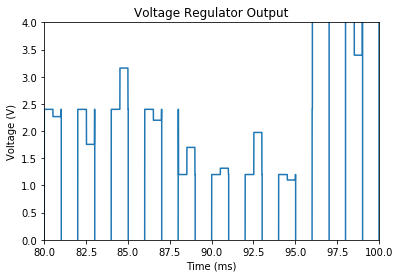

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

time = waveforms.time                # Time values for each point on the waveforms.
vout = waveforms[node(nodes[1])]

figure = plt.figure(1)
plt.title('Voltage Regulator Output')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.ylim(0,4)
plt.xlim(80,100)
plt.plot(time*1000, vout)
plt.show()

### The Result

## The PCB